# Tensorflow.keras implementation of one-bit-per-weight CNN for CIFAR 100 
##  https://arxiv.org/abs/1802.08530
## M. D. McDonnell, 
## Training wide residual networks for deployment using a single bit for each weight
## ICLR, 2018

In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import tensorflow
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History

#from tensorflow.keras import backend as K

from ResNetModel import resnet
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

Tensorflow version =  1.13.1


In [2]:
#params
#WhichDataSet = 'CIFAR10'
WhichDataSet = 'CIFAR100'
init_lr = 0.1
epochs = 254
batch_size = 125
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=True
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']
ModelsPath = 'TrainedModels/Tensorflow.keras/'

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#load and prepare data
if WhichDataSet == 'CIFAR10':
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


In [4]:
#fdefine a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
model = resnet(UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
model.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)

#print  the model
model.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [1.0,3.0, 7.0, 15.0, 31.0, 63.0,127.0,255.0]) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
binary_conv2d (BinaryConv2D)    (None, 32, 32, 160)  4320        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 32, 32, 160)  320         binary_conv2d[0][0]              
__________________________________________________________________________________________________
activation

In [5]:
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)

Instructions for updating:
Use tf.cast instead.

 Start of Epoch Learning Rate = 0.100000
Epoch 1/254
10000/10000 [==============================] - 7s 662us/sample - loss: 6.1754 - acc: 0.1786

 End of Epoch Learning Rate = 0.050005
400/400 [==============================] - 110s 276ms/step - loss: 6.8013 - acc: 0.1383 - val_loss: 6.1754 - val_acc: 0.1786

 Start of Epoch Learning Rate = 0.050005
Epoch 2/254
10000/10000 [==============================] - 6s 634us/sample - loss: 5.2958 - acc: 0.3194

 End of Epoch Learning Rate = 0.000010
400/400 [==============================] - 108s 270ms/step - loss: 5.6860 - acc: 0.2570 - val_loss: 5.2958 - val_acc: 0.3194

 Start of Epoch Learning Rate = 0.100000
Epoch 3/254
10000/10000 [==============================] - 6s 626us/sample - loss: 5.3281 - acc: 0.1982

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 108s 270ms/step - loss: 5.3018 - acc: 0.2555 - val_loss: 5.3281 - val_acc: 0.1982

 Start of Epoch Le

10000/10000 [==============================] - 6s 620us/sample - loss: 1.7742 - acc: 0.6688

 End of Epoch Learning Rate = 0.014653
400/400 [==============================] - 107s 268ms/step - loss: 1.6286 - acc: 0.7115 - val_loss: 1.7742 - val_acc: 0.6688

 Start of Epoch Learning Rate = 0.014653
Epoch 27/254
10000/10000 [==============================] - 6s 632us/sample - loss: 1.5220 - acc: 0.7198

 End of Epoch Learning Rate = 0.008436
400/400 [==============================] - 108s 269ms/step - loss: 1.5004 - acc: 0.7386 - val_loss: 1.5220 - val_acc: 0.7198

 Start of Epoch Learning Rate = 0.008436
Epoch 28/254
10000/10000 [==============================] - 6s 623us/sample - loss: 1.4225 - acc: 0.7405

 End of Epoch Learning Rate = 0.003816
400/400 [==============================] - 107s 268ms/step - loss: 1.3859 - acc: 0.7656 - val_loss: 1.4225 - val_acc: 0.7405

 Start of Epoch Learning Rate = 0.003816
Epoch 29/254
10000/10000 [==============================] - 6s 629us/sample -

10000/10000 [==============================] - 6s 621us/sample - loss: 1.8565 - acc: 0.6470

 End of Epoch Learning Rate = 0.022229
400/400 [==============================] - 107s 267ms/step - loss: 1.5105 - acc: 0.7410 - val_loss: 1.8565 - val_acc: 0.6470

 Start of Epoch Learning Rate = 0.022229
Epoch 53/254
10000/10000 [==============================] - 6s 620us/sample - loss: 1.6855 - acc: 0.6853

 End of Epoch Learning Rate = 0.018289
400/400 [==============================] - 107s 268ms/step - loss: 1.4396 - acc: 0.7554 - val_loss: 1.6855 - val_acc: 0.6853

 Start of Epoch Learning Rate = 0.018289
Epoch 54/254
10000/10000 [==============================] - 6s 623us/sample - loss: 1.5489 - acc: 0.7122

 End of Epoch Learning Rate = 0.014653
400/400 [==============================] - 107s 267ms/step - loss: 1.3600 - acc: 0.7723 - val_loss: 1.5489 - val_acc: 0.7122

 Start of Epoch Learning Rate = 0.014653
Epoch 55/254
10000/10000 [==============================] - 6s 620us/sample -

10000/10000 [==============================] - 6s 630us/sample - loss: 2.8568 - acc: 0.4808

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 107s 268ms/step - loss: 2.1472 - acc: 0.6270 - val_loss: 2.8568 - val_acc: 0.4808

 Start of Epoch Learning Rate = 0.085357
Epoch 79/254
10000/10000 [==============================] - 6s 626us/sample - loss: 3.2626 - acc: 0.3877

 End of Epoch Learning Rate = 0.083580
400/400 [==============================] - 107s 268ms/step - loss: 2.1174 - acc: 0.6335 - val_loss: 3.2626 - val_acc: 0.3877

 Start of Epoch Learning Rate = 0.083580
Epoch 80/254
10000/10000 [==============================] - 6s 623us/sample - loss: 2.5229 - acc: 0.5262

 End of Epoch Learning Rate = 0.081721
400/400 [==============================] - 107s 268ms/step - loss: 2.1003 - acc: 0.6364 - val_loss: 2.5229 - val_acc: 0.5262

 Start of Epoch Learning Rate = 0.081721
Epoch 81/254
10000/10000 [==============================] - 6s 625us/sample -

10000/10000 [==============================] - 6s 620us/sample - loss: 1.8471 - acc: 0.6574

 End of Epoch Learning Rate = 0.026438
400/400 [==============================] - 107s 268ms/step - loss: 1.4362 - acc: 0.7598 - val_loss: 1.8471 - val_acc: 0.6574

 Start of Epoch Learning Rate = 0.026438
Epoch 105/254
10000/10000 [==============================] - 6s 623us/sample - loss: 1.8779 - acc: 0.6461

 End of Epoch Learning Rate = 0.024302
400/400 [==============================] - 107s 268ms/step - loss: 1.3861 - acc: 0.7726 - val_loss: 1.8779 - val_acc: 0.6461

 Start of Epoch Learning Rate = 0.024302
Epoch 106/254
10000/10000 [==============================] - 6s 626us/sample - loss: 1.9511 - acc: 0.6316

 End of Epoch Learning Rate = 0.022229
400/400 [==============================] - 107s 268ms/step - loss: 1.3558 - acc: 0.7769 - val_loss: 1.9511 - val_acc: 0.6316

 Start of Epoch Learning Rate = 0.022229
Epoch 107/254
10000/10000 [==============================] - 6s 615us/sampl

10000/10000 [==============================] - 6s 623us/sample - loss: 3.2398 - acc: 0.3866

 End of Epoch Learning Rate = 0.099759
400/400 [==============================] - 107s 268ms/step - loss: 2.1916 - acc: 0.6103 - val_loss: 3.2398 - val_acc: 0.3866

 Start of Epoch Learning Rate = 0.099759
Epoch 131/254
10000/10000 [==============================] - 6s 617us/sample - loss: 3.0090 - acc: 0.4383

 End of Epoch Learning Rate = 0.099624
400/400 [==============================] - 107s 268ms/step - loss: 2.1890 - acc: 0.6192 - val_loss: 3.0090 - val_acc: 0.4383

 Start of Epoch Learning Rate = 0.099624
Epoch 132/254
10000/10000 [==============================] - 6s 624us/sample - loss: 2.8595 - acc: 0.4661

 End of Epoch Learning Rate = 0.099459
400/400 [==============================] - 107s 267ms/step - loss: 2.1973 - acc: 0.6220 - val_loss: 2.8595 - val_acc: 0.4661

 Start of Epoch Learning Rate = 0.099459
Epoch 133/254
10000/10000 [==============================] - 6s 614us/sampl

10000/10000 [==============================] - 6s 620us/sample - loss: 3.4837 - acc: 0.3501

 End of Epoch Learning Rate = 0.087049
400/400 [==============================] - 107s 268ms/step - loss: 2.1134 - acc: 0.6417 - val_loss: 3.4837 - val_acc: 0.3501

 Start of Epoch Learning Rate = 0.087049
Epoch 157/254
10000/10000 [==============================] - 6s 613us/sample - loss: 2.7149 - acc: 0.5033

 End of Epoch Learning Rate = 0.086214
400/400 [==============================] - 107s 266ms/step - loss: 2.1041 - acc: 0.6429 - val_loss: 2.7149 - val_acc: 0.5033

 Start of Epoch Learning Rate = 0.086214
Epoch 158/254
10000/10000 [==============================] - 6s 626us/sample - loss: 3.1438 - acc: 0.4043

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 107s 268ms/step - loss: 2.1026 - acc: 0.6450 - val_loss: 3.1438 - val_acc: 0.4043

 Start of Epoch Learning Rate = 0.085357
Epoch 159/254
10000/10000 [==============================] - 6s 627us/sampl

10000/10000 [==============================] - 6s 619us/sample - loss: 2.6080 - acc: 0.5191

 End of Epoch Learning Rate = 0.059759
400/400 [==============================] - 107s 267ms/step - loss: 1.8274 - acc: 0.6890 - val_loss: 2.6080 - val_acc: 0.5191

 Start of Epoch Learning Rate = 0.059759
Epoch 183/254
10000/10000 [==============================] - 6s 620us/sample - loss: 2.5780 - acc: 0.5139

 End of Epoch Learning Rate = 0.058552
400/400 [==============================] - 107s 267ms/step - loss: 1.8394 - acc: 0.6885 - val_loss: 2.5780 - val_acc: 0.5139

 Start of Epoch Learning Rate = 0.058552
Epoch 184/254
10000/10000 [==============================] - 6s 622us/sample - loss: 2.7240 - acc: 0.4906

 End of Epoch Learning Rate = 0.057341
400/400 [==============================] - 107s 268ms/step - loss: 1.8051 - acc: 0.6928 - val_loss: 2.7240 - val_acc: 0.4906

 Start of Epoch Learning Rate = 0.057341
Epoch 185/254
10000/10000 [==============================] - 6s 615us/sampl

10000/10000 [==============================] - 6s 624us/sample - loss: 2.1158 - acc: 0.5973

 End of Epoch Learning Rate = 0.028629
400/400 [==============================] - 107s 268ms/step - loss: 1.3826 - acc: 0.7736 - val_loss: 2.1158 - val_acc: 0.5973

 Start of Epoch Learning Rate = 0.028629
Epoch 209/254
10000/10000 [==============================] - 6s 619us/sample - loss: 2.1097 - acc: 0.6097

 End of Epoch Learning Rate = 0.027527
400/400 [==============================] - 107s 267ms/step - loss: 1.3727 - acc: 0.7741 - val_loss: 2.1097 - val_acc: 0.6097

 Start of Epoch Learning Rate = 0.027527
Epoch 210/254
10000/10000 [==============================] - 6s 627us/sample - loss: 2.0173 - acc: 0.6146

 End of Epoch Learning Rate = 0.026438
400/400 [==============================] - 107s 267ms/step - loss: 1.3458 - acc: 0.7800 - val_loss: 2.0173 - val_acc: 0.6146

 Start of Epoch Learning Rate = 0.026438
Epoch 211/254
10000/10000 [==============================] - 6s 628us/sampl

10000/10000 [==============================] - 6s 627us/sample - loss: 1.3394 - acc: 0.7585

 End of Epoch Learning Rate = 0.005913
400/400 [==============================] - 107s 267ms/step - loss: 0.7678 - acc: 0.9069 - val_loss: 1.3394 - val_acc: 0.7585

 Start of Epoch Learning Rate = 0.005913
Epoch 235/254
10000/10000 [==============================] - 6s 620us/sample - loss: 1.3247 - acc: 0.7595

 End of Epoch Learning Rate = 0.005348
400/400 [==============================] - 107s 268ms/step - loss: 0.7421 - acc: 0.9136 - val_loss: 1.3247 - val_acc: 0.7595

 Start of Epoch Learning Rate = 0.005348
Epoch 236/254
10000/10000 [==============================] - 6s 630us/sample - loss: 1.2661 - acc: 0.7714

 End of Epoch Learning Rate = 0.004810
400/400 [==============================] - 107s 267ms/step - loss: 0.7279 - acc: 0.9160 - val_loss: 1.2661 - val_acc: 0.7714

 Start of Epoch Learning Rate = 0.004810
Epoch 237/254
10000/10000 [==============================] - 6s 624us/sampl

In [6]:
#get final performance
y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 81.83


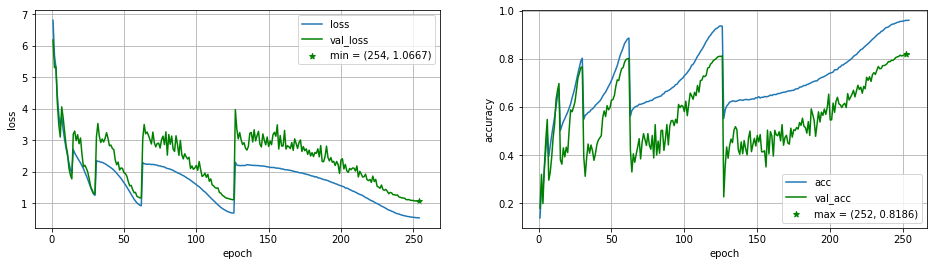

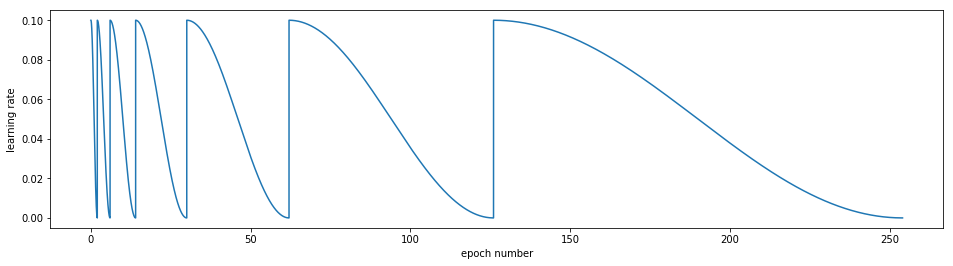

In [7]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()

In [8]:
#save the weigts used for updating
model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_OneBitPerWeight_model_v2.h5')

In [18]:
#create an inference model that uses regular conv2d layers
inference_model = resnet(UseBinaryWeights=False,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
inference_model.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)
inference_model.load_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_OneBitPerWeight_model_v2.h5')

#get accuracy:
y_pred = inference_model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

#doesn't work yet because sign and scale not yet applied, as we set UseBinaryWeights=False for inference_model

Test accuracy (%): 1.0


In [19]:
#convert weights to one bit storage in python and copy into the inference model

ZeroOneWeightsDict = {}
AllParamsDict={}
NumBinaryWeights=0.0
for layer in inference_model.layers:
    #print(layer.name)

    if 'conv2d' in layer.name:
        ww=layer.get_weights()
        layer.set_weights(np.sign(ww)*np.sqrt(2.0/np.prod(ww[0].shape[0:3])))
        
        #storage using 1 bit booleans
        binary_weights = (0.5*(np.sign(ww)+1.0)).astype('bool')
        ZeroOneWeightsDict[layer.name]=binary_weights
        AllParamsDict[layer.name]=binary_weights
        NumBinaryWeights+=np.prod(ww[0].shape)
    elif 'batch_normalization' in layer.name:
        #the saved model also nees floating point batch norm params
        ww=layer.get_weights()
        AllParamsDict[layer.name]=ww
        
savemat(ModelsPath+WhichDataSet+'_01weights.mat',ZeroOneWeightsDict,do_compression=True,long_field_names=True)
savemat(ModelsPath+WhichDataSet+'_allparams.mat',AllParamsDict,do_compression=True,long_field_names=True)
inference_model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_binarized.h5')

WeightsMemory=NumBinaryWeights/8/1024/1024
print('Num binary weights = ',int(NumBinaryWeights),'; weights memory = ',WeightsMemory,'  MB')

#get accuracy:
y_pred = inference_model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Num binary weights =  26794720 ; weights memory =  3.1941795349121094   MB
Test accuracy (%): 81.83


In [20]:
#verify 1 bit weights work perfectly when loaded from h5 file

inference_model.load_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_binarized.h5')

#verify each layer can take only two values:
cc=0
for layer in inference_model.layers:
    if 'conv2d' in layer.name:
        
        ww=layer.get_weights()
        uw = np.unique(ww)
        print('conv layer ',cc,' has ', len(uw),' unique weights')
        cc=cc+1

#get accuracy:
y_pred = inference_model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

conv layer  0  has  2  unique weights
conv layer  1  has  2  unique weights
conv layer  2  has  2  unique weights
conv layer  3  has  2  unique weights
conv layer  4  has  2  unique weights
conv layer  5  has  2  unique weights
conv layer  6  has  2  unique weights
conv layer  7  has  2  unique weights
conv layer  8  has  2  unique weights
conv layer  9  has  2  unique weights
conv layer  10  has  2  unique weights
conv layer  11  has  2  unique weights
conv layer  12  has  2  unique weights
conv layer  13  has  2  unique weights
conv layer  14  has  2  unique weights
conv layer  15  has  2  unique weights
conv layer  16  has  2  unique weights
conv layer  17  has  2  unique weights
conv layer  18  has  2  unique weights
conv layer  19  has  2  unique weights
Test accuracy (%): 81.83


In [21]:
#verify get the same results from compressed boolean storage
AllParamsDict_loaded=loadmat(ModelsPath+WhichDataSet+'_allparams.mat')


#verify each layer can take only two values:
#this requires layers saved with the same name as the most recently defined model
cc=0
for layer in inference_model.layers:
    if 'conv2d' in layer.name:
        ww=AllParamsDict_loaded[layer.name].astype('float32')*2.0-1.0
        ww=ww*np.sqrt(2.0/np.prod(ww[0].shape[0:3]))
        layer.set_weights([ww[0]])
        uw = np.unique(ww)
        print('conv layer ',cc,' has ', len(uw),' unique weights')
        cc=cc+1
    elif 'batch_normalization' in layer.name:
        #as a shortcut for this demo, note we already have the BN weights in the model
        #its a bit tedious wth .mat format to deal with the fact that BN layers can have a list of weights
        pass


#get accuracy:
y_pred = inference_model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

conv layer  0  has  2  unique weights
conv layer  1  has  2  unique weights
conv layer  2  has  2  unique weights
conv layer  3  has  2  unique weights
conv layer  4  has  2  unique weights
conv layer  5  has  2  unique weights
conv layer  6  has  2  unique weights
conv layer  7  has  2  unique weights
conv layer  8  has  2  unique weights
conv layer  9  has  2  unique weights
conv layer  10  has  2  unique weights
conv layer  11  has  2  unique weights
conv layer  12  has  2  unique weights
conv layer  13  has  2  unique weights
conv layer  14  has  2  unique weights
conv layer  15  has  2  unique weights
conv layer  16  has  2  unique weights
conv layer  17  has  2  unique weights
conv layer  18  has  2  unique weights
conv layer  19  has  2  unique weights
Test accuracy (%): 81.83
